In [1]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

from scipy.stats import norm, skewnorm, gamma

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import KoopmanProb
from model_objs import GammaNLL

In [4]:
all_data = pd.read_csv("atmo_chem//cfnrtStation0002643.csv")

In [5]:
# all_data['time'] = list(pd.Timestamp(year=all_data.year.loc[i], month=all_data.month.loc[i], day=all_data.day.loc[i], hour=all_data.hour.loc[i]) for i in all_data.index)

In [6]:
all_data[['location', 'year','month', 'day', 'hour', 'ISO8601']]

,location,year,month,day,hour,time
0,Station0002643,2018,1,1,0,2018-01-01 00:00:00
1,Station0002643,2018,1,1,1,2018-01-01 01:00:00
2,Station0002643,2018,1,1,2,2018-01-01 02:00:00
3,Station0002643,2018,1,1,3,2018-01-01 03:00:00
4,Station0002643,2018,1,1,4,2018-01-01 04:00:00
...,...,...,...,...,...,...
23227,Station0002643,2020,8,4,19,2020-08-04 19:00:00
23228,Station0002643,2020,8,4,20,2020-08-04 20:00:00
23229,Station0002643,2020,8,4,21,2020-08-04 21:00:00
23230,Station0002643,2020,8,4,22,2020-08-04 22:00:00


In [7]:
all_data.columns

Index(['ISO8601', 'location', 'lat', 'lon', 'CLDTT', 'PS', 'Q10M', 'T10M',
       'TPREC', 'TS', 'U10M', 'V10M', 'ZPBL', 'NO2', 'NO', 'NOy', 'O3', 'CO',
       'ACET', 'ALK4', 'ALD2', 'HCHO', 'C2H6', 'C3H8', 'BCPI', 'BCPO', 'OCPI',
       'OCPO', 'EOH', 'DST1', 'DST2', 'DST3', 'DST4', 'H2O2', 'HNO3', 'HNO4',
       'ISOP', 'MACR', 'MEK', 'MVK', 'N2O5', 'NH3', 'NH4', 'NIT', 'PAN',
       'PRPE', 'RCHO', 'SALA', 'SALC', 'SO2', 'SOAP', 'SOAS', 'TOLU', 'XYLE',
       'PM25_RH35_GCC', 'PM25ni_RH35_GCC', 'PM25su_RH35_GCC',
       'PM25ss_RH35_GCC', 'PM25du_RH35_GCC', 'PM25bc_RH35_GCC',
       'PM25oc_RH35_GCC', 'PM25soa_RH35_GCC', 'PM25_RH35_GOCART', 'EMIS_NO',
       'EMIS_CO', 'EMIS_ACET', 'EMIS_ALD2', 'EMIS_ALK4', 'EMIS_BENZ',
       'EMIS_C2H6', 'EMIS_C3H8', 'EMIS_HCHO', 'EMIS_EOH', 'EMIS_MEK',
       'EMIS_NH3', 'EMIS_PRPE', 'EMIS_TOLU', 'EMIS_XYLE', 'EMIS_ISOP',
       'EMIS_BCPI', 'EMIS_BCPO', 'EMIS_OCPI', 'EMIS_OCPO', 'EMIS_DST1',
       'EMIS_DST2', 'EMIS_DST3', 'EMIS_DST4', 'EMIS_S

In [31]:
# %matplotlib inline
# for col in all_data.columns[90:94]:
#     plt.plot(all_data[col].values)
#     plt.show()
#     plt.plot(all_data[col].iloc[2000:2720].values)
#     plt.show()
#     print(col, "\n\n\n")


In [11]:
all_data.ISO8601

0        2018-01-01T00:00:00Z
1        2018-01-01T01:00:00Z
2        2018-01-01T02:00:00Z
3        2018-01-01T03:00:00Z
4        2018-01-01T04:00:00Z
                 ...         
23227    2020-08-04T19:30:00Z
23228    2020-08-04T20:30:00Z
23229    2020-08-04T21:30:00Z
23230    2020-08-04T22:30:00Z
23231    2020-08-04T23:30:00Z
Name: ISO8601, Length: 23232, dtype: object

In [12]:
# for flu data/integer data, use smooth parameter, discrete probability dist
# NO2, O3, NO, HNO4, ISOP, N2O5, NIT, PRPE, SOAP
# EMIS --all of them have very strong daily, weekly, and annual patterns
# EMIS_ISOP (cleaner version of NO)
%matplotlib notebook
# plt.plot(all_data.time, all_data.NO)

In [13]:
x = np.expand_dims(all_data.NO.values, -1)  # Nitric Oxide

In [14]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[18228]


In [15]:
x_original = x
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)

x (23232, 1)


In [16]:
data_name = "firstNOtest"

train_through = 2 * 365 * 24
train_start = 0
delay = 0  # 52 * 24  # 1.5 to 2 month gap, then 1 month forecast
x = x[train_start:]
predict_through = train_through + 24 * 365 + delay  
x = x[:predict_through]
xt = x[:train_through]

num_freqs = [5, 5]
num_fourier = 2
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (23232, 1)
xt (17520, 1)


In [17]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [18]:
k.find_fourier_omegas(xt, hard_code=[24, 24 * 365.25])  # Day, Year

tensor([0.2618, 0.0007])

In [19]:
k.fit(xt, iterations=300, interval=10, verbose=True, cutoff=50, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Setting 2 to 2.0000285392878974
Setting 3 to 140159.66666666666
Setting 4 to 73126.78260869565
Setting 7 to 93439.77777777778
Setting 8 to 88521.8947368421
Setting 9 to 98936.23529411765
Iteration  0
tensor([2.4000e+01, 8.7660e+03, 2.0000e+00, 1.4016e+05, 7.3127e+04, 2.4000e+01,
        8.7660e+03, 9.3440e+04, 8.8522e+04, 9.8936e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 2.0000e+00, 1.4016e+05, 7.3127e+04, 2.4000e+01,
        8.7660e+03, 9.3440e+04, 8.8522e+04, 9.8936e+04],
       grad_fn=<MulBackward0>)
Loss:  -2.00422
Iteration  1
tensor([2.4000e+01, 8.7660e+03, 2.0000e+00, 1.4016e+05, 7.3127e+04, 2.4000e+01,
        8.7660e+03, 9.3440e+04, 8.8522e+04, 9.8936e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 2.0000e+00, 1.4016e+05, 7.3127e+04, 2.4000e+01,
        8.7660e+03, 9.3440e+04, 8.8522e+04, 9.8936e+04],
       grad_fn=<MulBackward0>)
Loss:  -2.4923544
Iteration  2
tensor([2.4000e+01, 8.7660e+03, 2.0000e+00, 1.4016e+05, 7.3127e+04, 2.4000e+01,
        8.76

Setting periods to tensor([2.4000e+01, 8.7660e+03, 2.0000e+00, 4.2048e+05, 1.6819e+06, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 1.5152e+04, 2.1290e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.0456042
Iteration  23
tensor([2.4000e+01, 8.7660e+03, 2.0000e+00, 4.2048e+05, 1.6819e+06, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 1.5152e+04, 2.1290e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 2.0000e+00, 4.2048e+05, 1.6819e+06, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 1.5152e+04, 2.1290e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.0611265
Iteration  24
tensor([2.4000e+01, 8.7660e+03, 2.0000e+00, 4.2048e+05, 1.6819e+06, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 1.5152e+04, 2.1290e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 2.0000e+00, 4.2048e+05, 1.6819e+06, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 1.5152e+04, 2.1290e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.0761857
Iteration  25
tensor([2.4000e+01, 8.7660e+03, 2.0000e+00, 4.2048e+05, 1.6819e+06, 2

Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.2114868
Iteration  46
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.2192698
Iteration  47
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.227619
Iteration  48
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.

Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3226593
Iteration  70
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.325761
Iteration  71
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3275976
Iteration  72
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.

Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3505917
Iteration  94
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.351583
Iteration  95
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3519392
Iteration  96
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.

Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3585846
Iteration  117
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3577678
Iteration  118
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3572688
Iteration  119
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00

Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3609478
Iteration  140
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3604195
Iteration  141
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3620129
Iteration  142
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00

Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3637958
Iteration  163
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.364857
Iteration  164
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3649817
Iteration  165
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00,

Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3681073
Iteration  186
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3673823
Iteration  187
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3683484
Iteration  188
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00

Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3702936
Iteration  209
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.370554
Iteration  210
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.371041
Iteration  211
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 

Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.374456
Iteration  232
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3740087
Iteration  233
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3754315
Iteration  234
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00,

Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3781395
Iteration  255
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3790371
Iteration  256
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3782265
Iteration  257
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00

Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3810596
Iteration  278
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.381662
Iteration  279
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04])
Setting periods to tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00, 2.4000e+01,
        8.7660e+03, 2.0002e+00, 4.0005e+00, 2.0511e+04],
       grad_fn=<MulBackward0>)
Loss:  -3.3814535
Iteration  280
tensor([2.4000e+01, 8.7660e+03, 4.0000e+00, 4.2048e+05, 2.0000e+00,

In [20]:
params = k.predict(predict_through)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

## Get Quantiles

In [21]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [22]:
quantiles = np.array([30, 60, 85, 98], dtype=np.float32) / 100
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

<IPython.core.display.Javascript object>


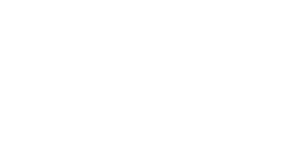

In [23]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    plt.plot(x[:predict_through, dim], label="data")
#     plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
#     plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
#     plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    
    colors = [(i / len(quantiles), 0, 0) for i in range(len(quantiles))]
    for j in range(0, len(quantiles), 1):
        plt.plot(quant_preds[:, j], color=colors[j], linewidth=0.15, label=quantiles[j])

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

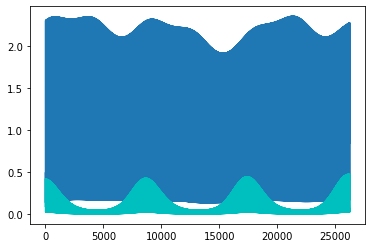

In [24]:
%matplotlib inline
plt.plot(a_hat)
plt.plot(1/rate_hat, color="c")

In [50]:
print("actual overall mean:", np.mean(xt), " predicted mean:", np.mean(mean_hat[:train_through]))

actual overall mean: 0.032887004285542226  predicted mean: 0.03298049


In [10]:
a = 1.15
scale = 1 / 50
lins = np.linspace(1e-4, 1, 100)
gampdf = gamma.pdf(lins, a, scale=scale)

<IPython.core.display.Javascript object>


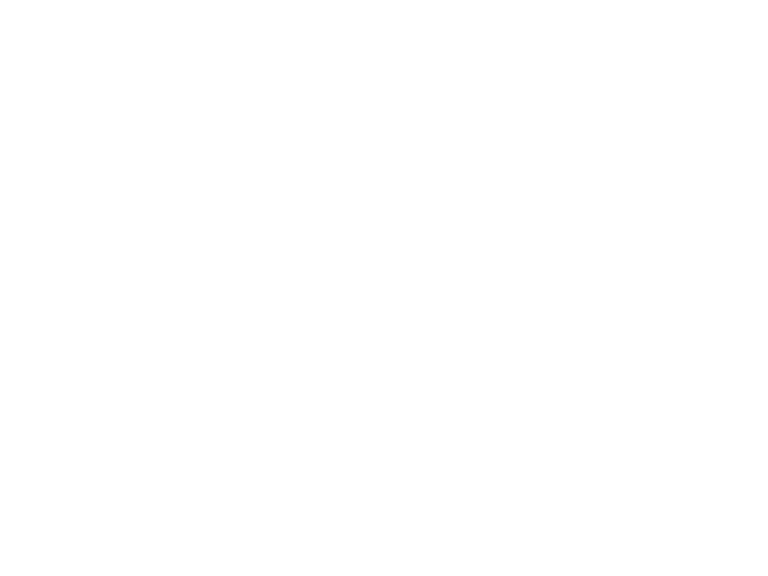

NameError: name 'x' is not defined

In [11]:
%matplotlib notebook
plt.figure()
hist, bin_edges = np.histogram(x[:24 * 20, 0], bins=100, range=(0, 1), density=True)
plt.plot(lins, hist, label="data")
plt.plot(lins, gampdf, label="Average fit")

plt.xlabel("[NO] in air")
plt.ylabel("probability density")
plt.legend()
# plt.semilogx()
plt.semilogy()
plt.show()

In [51]:
"mean of a_hat", np.mean(a_hat), "std of a_hat", np.std(a_hat)

('mean of a_hat', 1.2497509, 'std of a_hat', 1.0879974)

In [41]:
f = np.array([True, False])

In [42]:
~f

array([False,  True])